In [1]:
#!pip install numpy
#!pip install scipy
#!pip install torch
#!pip install torch_geometric
#!pip install matplotlib
#!pip install scikit-learn
#!pip install pandas
#!pip install torchmetrics

In [2]:
#!pip freeze > requirements.txt

In [3]:
# Install required packages.
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:
# Import FlyWire connections as an edgelist
neurons = pd.read_csv('FlyWire_data/classification.csv')
neurons

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN
...,...,...,...,...,...,...,...,...,...,...
139250,720575940632239661,afferent,sensory,olfactory,NaN,ORN_VM6l,ORN_VC5,NaN,right,AN
139251,720575940624423312,intrinsic,optic,NaN,NaN,TmY5a,NaN,NaN,right,NaN
139252,720575940625090916,intrinsic,optic,NaN,NaN,NaN,NaN,NaN,left,NaN
139253,720575940631596103,intrinsic,optic,NaN,NaN,T2a,NaN,NaN,left,NaN


In [6]:
neurons['super_class'].value_counts()

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [7]:
# Import FlyWire connections as an edgelist
connections = pd.read_csv('FlyWire_data/connections.csv')
connections

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [8]:
def compute_homophily(edge_index, y):
    # Ensure edge_index is undirected
    row, col = edge_index
    same_label = (y[row] == y[col])
    return same_label.sum().item() / edge_index.size(1)

In [9]:
results = []
for blah in connections['neuropil'].unique():
    temp1 = connections[connections['neuropil'].isin([blah])]
    lh_neurons = list(np.unique(list(temp1['pre_root_id']) + list(temp1['post_root_id']))) # Subselect neurons in neuropil of interest
    temp2 = neurons[neurons['root_id'].isin(lh_neurons)]
    temp2 = temp2[temp2['super_class'].map(temp2['super_class'].value_counts()) >= 20]
    results.append(len(temp2['super_class'].unique()))

In [10]:
np.argmax(results)

np.int64(8)

In [25]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

In [26]:
np.argsort(results)[-4]

np.int64(3)

In [27]:
results[np.argsort(results)[-4]]

6

In [28]:
results[-4]

1

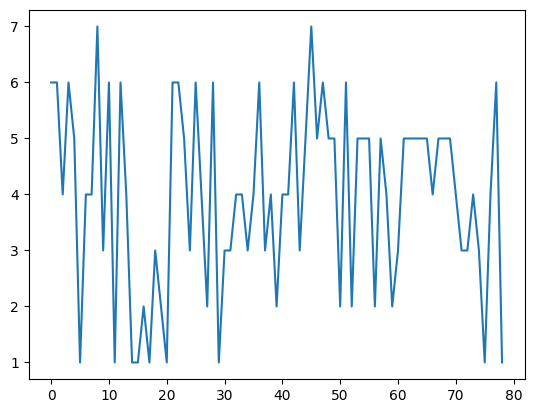

In [29]:
plt.plot(results)

In [30]:
connections['neuropil'].unique()[np.argmax(results)]
connections['neuropil'].unique()[np.argsort(results)[-4]]

'SMP_R'

In [31]:
results2 = []
for blah in np.argsort(results):
    neuropils_of_interest = [connections['neuropil'].unique()[blah]]
    temp1 = connections[connections['neuropil'].isin(neuropils_of_interest)]
    lh_neurons = list(np.unique(list(temp1['pre_root_id']) + list(temp1['post_root_id']))) # Subselect neurons in neuropil of interest
    temp2 = neurons[neurons['root_id'].isin(lh_neurons)]
    temp2 = temp2[temp2['super_class'].map(temp2['super_class'].value_counts()) >= 20]
    valid_ids = set(temp2['root_id'])
    temp1 = temp1[
        temp1['pre_root_id'].isin(valid_ids) & 
        temp1['post_root_id'].isin(valid_ids)
    ]
    temp1 = temp1.astype({"syn_count": 'float32'})
    G = nx.DiGraph() # Initialize a networkx directed graph 
    G = nx.from_pandas_edgelist(temp1, 'pre_root_id', 'post_root_id', ['syn_count'], create_using=nx.DiGraph()) # Create a graph with our node and edge information
    graph = from_networkx(G, group_edge_attrs=['syn_count']) # Add edge attributes from networkx graph
    graph.y = torch.from_numpy(np.copy(pd.Categorical(temp2['super_class']).codes)).long()
    results2.append(compute_homophily(graph.edge_index, graph.y))

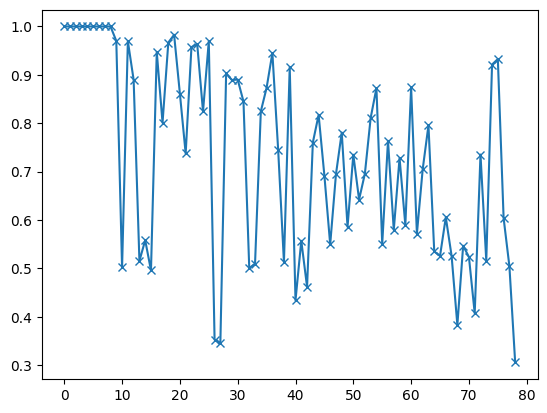

In [32]:
plt.plot(results2, "x-")

In [33]:
neuropils_of_interest = ['GNG']
#neuropils_of_interest = ['LH_L']
#neuropils_of_interest = [connections['neuropil'].unique()[np.argsort(results)[-4]]]
#neuropils_of_interest = ['SMP_R']
connections = connections[connections['neuropil'].isin(neuropils_of_interest)]
lh_neurons = list(np.unique(list(connections['pre_root_id']) + list(connections['post_root_id']))) # Subselect neurons in neuropil of interest
neurons = neurons[neurons['root_id'].isin(lh_neurons)]

In [34]:
neurons = neurons[neurons['super_class'].map(neurons['super_class'].value_counts()) >= 20]

In [35]:
neurons

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
5,720575940632934751,efferent,descending,NaN,NaN,DNge094,NaN,LB7,right,CV
14,720575940635859354,intrinsic,central,NaN,NaN,NaN,IB008,putative_primary,left,NaN
29,720575940623371920,afferent,ascending,AN,AN_GNG,AN_GNG_186,NaN,NaN,right,CV
43,720575940622835947,intrinsic,central,NaN,NaN,CB1120,NaN,TRdl_b,right,NaN
...,...,...,...,...,...,...,...,...,...,...
139213,720575940651145857,afferent,ascending,AN,AN_IPS_GNG,AN_IPS_GNG_7,NaN,NaN,right,CV
139214,720575940604781158,afferent,sensory,mechanosensory,NaN,NaN,NaN,NaN,right,AN
139221,720575940624108060,afferent,ascending,AN,AN_GNG_IPS,AN_GNG_IPS_19,NaN,NaN,right,CV
139222,720575940640173184,afferent,ascending,AN,AN_GNG,AN_GNG_93,NaN,NaN,right,CV


In [36]:
neurons['super_class'].value_counts()

super_class
central               4703
sensory               1981
ascending             1892
descending            1190
visual_centrifugal     135
motor                  100
visual_projection       75
Name: count, dtype: int64

In [37]:
len(neurons['super_class'].unique())

7

In [38]:
valid_ids = set(neurons['root_id'])
connections = connections[
    connections['pre_root_id'].isin(valid_ids) & 
    connections['post_root_id'].isin(valid_ids)
]

In [39]:
connections

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
14,720575940625002936,720575940632028216,GNG,76,GABA
96,720575940628344074,720575940631299090,GNG,92,ACH
111,720575940617986683,720575940621218694,GNG,12,ACH
126,720575940610981362,720575940637130985,GNG,3,ACH
138,720575940635202155,720575940626960536,GNG,15,ACH
...,...,...,...,...,...
3869756,720575940623776743,720575940654220193,GNG,1,ACH
3869771,720575940629595633,720575940621736669,GNG,1,GABA
3869779,720575940632274914,720575940622474899,GNG,2,GABA
3869782,720575940607380914,720575940632634532,GNG,5,GABA


In [40]:
# Edge attributes: The strength of connectivity (synaptic count) of each connection
connections = connections.astype({"syn_count": 'float32'})

In [41]:
# networkx graph -> PyTorch geometric object transformation is easy
G = nx.DiGraph() # Initialize a networkx directed graph 
G = nx.from_pandas_edgelist(connections, 'pre_root_id', 'post_root_id', ['syn_count'], create_using=nx.DiGraph()) # Create a graph with our node and edge information

In [42]:
# Convert graph into PyTorch geometric object
graph = from_networkx(G, group_edge_attrs=['syn_count']) # Add edge attributes from networkx graph

In [43]:
graph.y = torch.from_numpy(np.copy(pd.Categorical(neurons['super_class']).codes)).long()

In [44]:
homophily = compute_homophily(graph.edge_index, graph.y)
print(f"Homophily: {homophily:.4f}")

Homophily: 0.3054


In [45]:
num_classes = len(graph.y.unique())
num_classes

7

In [46]:
graph.num_nodes = graph.y.size(0)

In [47]:
import torch.nn.functional as F

#graph.x = nt_onehot
graph.x = F.one_hot(graph.y, num_classes=num_classes).float()
#graph.x = torch.randn_like(graph.x)
#graph.x = torch.full_like(graph.x, 1.0 / num_classes)

In [48]:
def mask_val_test(X, test_mask, val_mask):
    X_masked = X.clone()
    X_masked[test_mask] = 0.0
    X_masked[val_mask] = 0.0
    return X_masked

In [49]:
import torch_geometric.transforms as T

torch.manual_seed(1325)
# Define the transform
transform = T.RandomNodeSplit(split='train_rest', num_val=0.4, num_test=0.4)

# Apply it to your graph
graph = transform(graph)

In [50]:
graph.x[graph.test_mask] = 0. 
graph.x[graph.val_mask] = 0. 
#mask_val_test(graph.x, graph.test_mask, graph.val_mask)
#graph.x = mask_all_train_features(graph.x, graph.train_mask)
#graph.x = mask_all_train_features_uniform(graph.x, graph.train_mask, num_classes)
#graph.x = mask_partial_train_features_uniform(graph.x, graph.train_mask, num_classes, frac=0.8)
#graph.x = mask_features_uniform(graph.x, num_classes, mask_prob=0.4)
#graph.x = mask_features(graph.x, mask_prob=0.5)
# Smoothed one-hot
#graph.x = 0.3 * graph.x + 0.7 / num_classes

In [51]:
torch.sum(graph.x[graph.train_mask],dim=0)

tensor([381., 945., 235.,  23., 382.,  33.,  17.])

In [52]:
graph.x[graph.val_mask]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [53]:
num_features = graph.x.shape[1]
num_nodes = graph.x.shape[0]

In [54]:
# Compute class weights
label_counts = torch.bincount(graph.y[graph.train_mask])
class_weights = 1.0 / label_counts.float()
class_weights = class_weights / class_weights.sum()  # normalize if you want

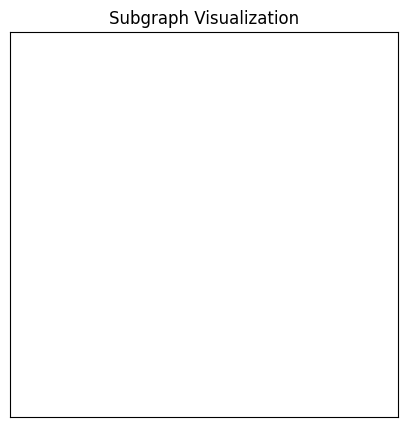

In [55]:
from torch_geometric.utils import subgraph, to_networkx
import networkx as nx

# Draw subgraph
plt.figure(figsize=(5, 5))
#nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=8)
plt.xticks([])
plt.yticks([])
plt.title("Subgraph Visualization")
plt.show()

In [56]:
import torch
torch.save(graph, 'GNG_graph.pt')

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a neuron solely based on its content, *i.e.* its actvity feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [368]:
import torch
from torch.nn import Linear

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout only active during training
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=6, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [369]:
num_classes

6

In [370]:
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassF1Score

metric = MulticlassMatthewsCorrCoef(num_classes=num_classes)  # Set your number of classes
metric = MulticlassAUROC(num_classes=num_classes, average='macro')  # or 'weighted'
metric = MulticlassF1Score(num_classes=num_classes, average='macro')

In [371]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Define loss criterion.
#criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

      # --- Validation error ---
      model.eval()  # switch to eval mode (disables dropout, etc.)
      with torch.no_grad():
            pred = out.argmax(dim=1)
            val_pred = pred[graph.val_mask]
            val_true = graph.y[graph.val_mask]
            val_acc = (val_pred == val_true).float().mean().item()
    
      return loss.item(), val_acc

def test():
      model.eval()
      out = model(graph.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      mcc = metric(pred[graph.test_mask], graph.y[graph.test_mask])    
      auc = metric(out[graph.test_mask], graph.y[graph.test_mask]) 
      f1 = metric(pred[graph.test_mask], graph.y[graph.test_mask])

      return test_acc

for epoch in range(1, 1001):
    loss, val_acc = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val_acc: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.8109, val_acc: 0.8566
Epoch: 002, Loss: 1.8047, val_acc: 0.8010
Epoch: 003, Loss: 1.7576, val_acc: 0.7350
Epoch: 004, Loss: 1.7377, val_acc: 0.7143
Epoch: 005, Loss: 1.7156, val_acc: 0.6512
Epoch: 006, Loss: 1.6856, val_acc: 0.5805
Epoch: 007, Loss: 1.7041, val_acc: 0.5062
Epoch: 008, Loss: 1.6824, val_acc: 0.4410
Epoch: 009, Loss: 1.6541, val_acc: 0.4191
Epoch: 010, Loss: 1.6137, val_acc: 0.3266
Epoch: 011, Loss: 1.6154, val_acc: 0.2435
Epoch: 012, Loss: 1.5707, val_acc: 0.2451
Epoch: 013, Loss: 1.5817, val_acc: 0.1947
Epoch: 014, Loss: 1.5266, val_acc: 0.1696
Epoch: 015, Loss: 1.5663, val_acc: 0.1216
Epoch: 016, Loss: 1.5394, val_acc: 0.1132
Epoch: 017, Loss: 1.4879, val_acc: 0.0950
Epoch: 018, Loss: 1.3849, val_acc: 0.0965
Epoch: 019, Loss: 1.3847, val_acc: 0.0969
Epoch: 020, Loss: 1.3800, val_acc: 0.1025
Epoch: 021, Loss: 1.3855, val_acc: 0.0902
Epoch: 022, Loss: 1.3493, val_acc: 0.0810
Epoch: 023, Loss: 1.3453, val_acc: 0.0985
Epoch: 024, Loss: 1.3149, val_acc:

In [372]:
from sklearn.metrics import confusion_matrix, classification_report

# Assume:
# - y_true: ground truth labels of test nodes
# - y_pred: predicted labels of test nodes

# Example:
y_pred = model(graph.x).argmax(dim=1) 
y_true = graph.y

# Use the test mask to slice out test nodes
y_pred_test = y_pred[graph.test_mask]
y_true_test = y_true[graph.test_mask]

# Confusion matrix
cm = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu())
print("Confusion Matrix:\n", cm)

# Classification report (includes precision, recall, F1 per class)
report = classification_report(y_true_test.cpu(), y_pred_test.cpu(), digits=3)
print("Classification Report:\n", report)

Confusion Matrix:
 [[   0    0    0    0    0   17]
 [   0    0    0    0    0 2418]
 [   0    0    0    0    0   24]
 [   0    0    0    0    0   16]
 [   0    0    0    0    0   16]
 [   0    0    0    0    0   26]]
Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000        17
           1      0.000     0.000     0.000      2418
           2      0.000     0.000     0.000        24
           3      0.000     0.000     0.000        16
           4      0.000     0.000     0.000        16
           5      0.010     1.000     0.020        26

    accuracy                          0.010      2517
   macro avg      0.002     0.167     0.003      2517
weighted avg      0.000     0.010     0.000      2517



/Users/briandepasquale/Documents/GitHub/CoSyNe_2025_GNN_tutorial/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/briandepasquale/Documents/GitHub/CoSyNe_2025_GNN_tutorial/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/briandepasquale/Documents/GitHub/CoSyNe_2025_GNN_tutorial/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

In [373]:
torch.bincount(graph.y)

tensor([  42, 6045,   72,   41,   33,   59])

In [374]:
torch.bincount(y_pred, minlength=num_classes)

tensor([  10, 1202,   22,    4,    8, 5046])

After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [375]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.0103


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [376]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout only active during training
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 6)
)


In [377]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

      # --- Validation error ---
      model.eval()  # switch to eval mode (disables dropout, etc.)
      with torch.no_grad():
            pred = out.argmax(dim=1)
            val_pred = pred[graph.val_mask]
            val_true = graph.y[graph.val_mask]
            val_acc = (val_pred == val_true).float().mean().item()
    
      return loss.item(), val_acc

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      mcc = metric(pred[graph.test_mask], graph.y[graph.test_mask])
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      f1 = metric(pred[graph.test_mask], graph.y[graph.test_mask])
      return test_acc


for epoch in range(1, 1001):
    loss, val_acc = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val_error: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.7816, val_error: 0.5383
Epoch: 002, Loss: 1.7822, val_error: 0.6253
Epoch: 003, Loss: 1.8085, val_error: 0.5280
Epoch: 004, Loss: 1.7932, val_error: 0.4887
Epoch: 005, Loss: 1.7917, val_error: 0.4501
Epoch: 006, Loss: 1.7743, val_error: 0.4048
Epoch: 007, Loss: 1.7606, val_error: 0.3548
Epoch: 008, Loss: 1.7464, val_error: 0.3119
Epoch: 009, Loss: 1.7360, val_error: 0.3178
Epoch: 010, Loss: 1.7419, val_error: 0.3083
Epoch: 011, Loss: 1.7337, val_error: 0.3067
Epoch: 012, Loss: 1.7335, val_error: 0.2332
Epoch: 013, Loss: 1.7430, val_error: 0.2626
Epoch: 014, Loss: 1.7378, val_error: 0.2567
Epoch: 015, Loss: 1.7194, val_error: 0.2630
Epoch: 016, Loss: 1.7201, val_error: 0.2710
Epoch: 017, Loss: 1.7117, val_error: 0.2749
Epoch: 018, Loss: 1.7131, val_error: 0.2765
Epoch: 019, Loss: 1.6748, val_error: 0.2833
Epoch: 020, Loss: 1.6916, val_error: 0.2813
Epoch: 021, Loss: 1.7191, val_error: 0.2896
Epoch: 022, Loss: 1.6938, val_error: 0.2841
Epoch: 023, Loss: 1.6722, val_er

In [378]:
# Assume:
# - y_true: ground truth labels of test nodes
# - y_pred: predicted labels of test nodes

# Example:
y_pred = model(graph.x, graph.edge_index).argmax(dim=1)
y_true = graph.y

# Use the test mask to slice out test nodes
y_pred_test = y_pred[graph.test_mask]
y_true_test = y_true[graph.test_mask]

# Confusion matrix
cm = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu())
print("Confusion Matrix:\n", cm)

# Classification report (includes precision, recall, F1 per class)
report = classification_report(y_true_test.cpu(), y_pred_test.cpu(), digits=3)
print("Classification Report:\n", report)

Confusion Matrix:
 [[   1   10    0    0    6    0]
 [  68 1362   44  139  769   36]
 [   2   16    0    3    3    0]
 [   1    9    0    1    4    1]
 [   0   10    0    3    3    0]
 [   0   14    0    2    9    1]]
Classification Report:
               precision    recall  f1-score   support

           0      0.014     0.059     0.022        17
           1      0.958     0.563     0.710      2418
           2      0.000     0.000     0.000        24
           3      0.007     0.062     0.012        16
           4      0.004     0.188     0.007        16
           5      0.026     0.038     0.031        26

    accuracy                          0.544      2517
   macro avg      0.168     0.152     0.130      2517
weighted avg      0.921     0.544     0.682      2517



In [379]:
torch.bincount(graph.y)

tensor([  42, 6045,   72,   41,   33,   59])

In [380]:
torch.bincount(y_pred, minlength=num_classes)

tensor([ 170, 3803,  132,  353, 1736,   98])

After training the model, we can check its test accuracy:

In [381]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5435


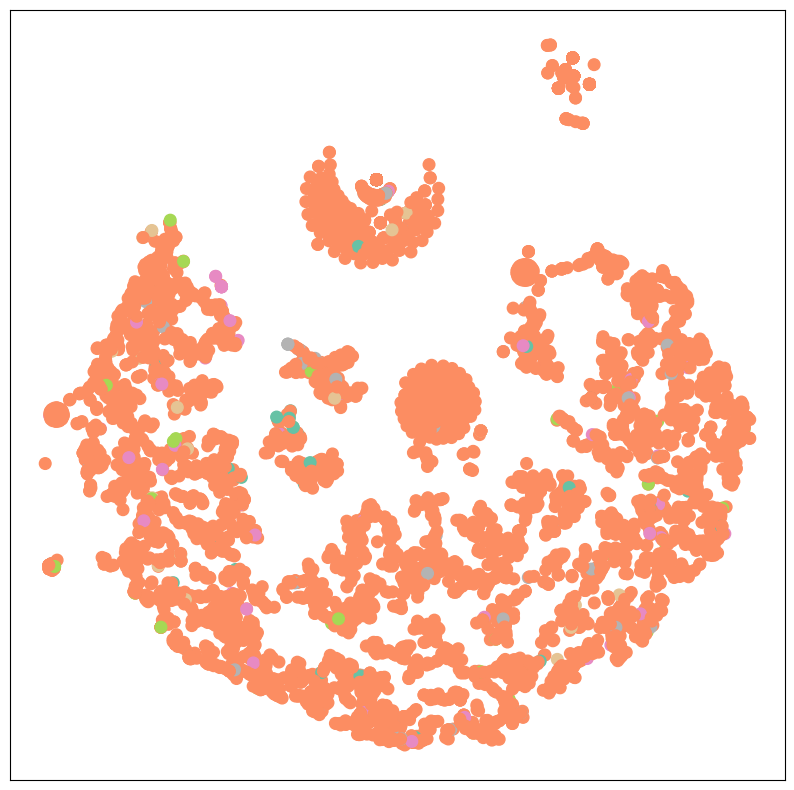

In [382]:
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

In [383]:
from torch_geometric.nn import GATConv

# Assuming num_features and num_classes are defined globally
# e.g., num_features = dataset.num_features, num_classes = dataset.num_classes

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_features, hidden_channels, heads=8, dropout=0.0)
        # Output dim of conv1 is hidden_channels * heads, so we set in_channels accordingly
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=False, dropout=0.0)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout only active during training
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16)
print(model)

GAT(
  (conv1): GATConv(6, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


In [384]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

      # --- Validation error ---
      model.eval()  # switch to eval mode (disables dropout, etc.)
      with torch.no_grad():
            pred = out.argmax(dim=1)
            val_pred = pred[graph.val_mask]
            val_true = graph.y[graph.val_mask]
            val_acc = (val_pred == val_true).float().mean().item()
    
      return loss.item(), val_acc

def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      mcc = metric(pred[graph.test_mask], graph.y[graph.test_mask])
      f1 = metric(pred[graph.test_mask], graph.y[graph.test_mask])
      return test_acc


for epoch in range(1, 1001):
    loss, val_acc = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val_error: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.7874, val_error: 0.1442
Epoch: 002, Loss: 1.7570, val_error: 0.4998
Epoch: 003, Loss: 1.7265, val_error: 0.5419
Epoch: 004, Loss: 1.6803, val_error: 0.5538
Epoch: 005, Loss: 1.6605, val_error: 0.5157
Epoch: 006, Loss: 1.6137, val_error: 0.4648
Epoch: 007, Loss: 1.6030, val_error: 0.4025
Epoch: 008, Loss: 1.5797, val_error: 0.3603
Epoch: 009, Loss: 1.5633, val_error: 0.3031
Epoch: 010, Loss: 1.5104, val_error: 0.2634
Epoch: 011, Loss: 1.5064, val_error: 0.2169
Epoch: 012, Loss: 1.4755, val_error: 0.1824
Epoch: 013, Loss: 1.4715, val_error: 0.1474
Epoch: 014, Loss: 1.4086, val_error: 0.1232
Epoch: 015, Loss: 1.3895, val_error: 0.1188
Epoch: 016, Loss: 1.3811, val_error: 0.1152
Epoch: 017, Loss: 1.3708, val_error: 0.1116
Epoch: 018, Loss: 1.3325, val_error: 0.1045
Epoch: 019, Loss: 1.3117, val_error: 0.1156
Epoch: 020, Loss: 1.2997, val_error: 0.1065
Epoch: 021, Loss: 1.2633, val_error: 0.0989
Epoch: 022, Loss: 1.2514, val_error: 0.1045
Epoch: 023, Loss: 1.2328, val_er

In [386]:
# Assume:
# - y_true: ground truth labels of test nodes
# - y_pred: predicted labels of test nodes

# Example:
y_pred = model(graph.x, graph.edge_index).argmax(dim=1)
y_true = graph.y

# Use the test mask to slice out test nodes
y_pred_test = y_pred[graph.test_mask]
y_true_test = y_true[graph.test_mask]

# Confusion matrix
cm = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu())
print("Confusion Matrix:\n", cm)

# Classification report (includes precision, recall, F1 per class)
report = classification_report(y_true_test.cpu(), y_pred_test.cpu(), digits=3)
print("Classification Report:\n", report)

Confusion Matrix:
 [[   3    7    0    0    1    6]
 [  57 1585   75   22   47  632]
 [   2   18    2    0    0    2]
 [   0   11    0    1    0    4]
 [   0   11    0    0    0    5]
 [   0   16    0    1    0    9]]
Classification Report:
               precision    recall  f1-score   support

           0      0.048     0.176     0.076        17
           1      0.962     0.656     0.780      2418
           2      0.026     0.083     0.040        24
           3      0.042     0.062     0.050        16
           4      0.000     0.000     0.000        16
           5      0.014     0.346     0.026        26

    accuracy                          0.636      2517
   macro avg      0.182     0.221     0.162      2517
weighted avg      0.925     0.636     0.750      2517



In [387]:
torch.bincount(graph.y)

tensor([  42, 6045,   72,   41,   33,   59])

In [388]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6357


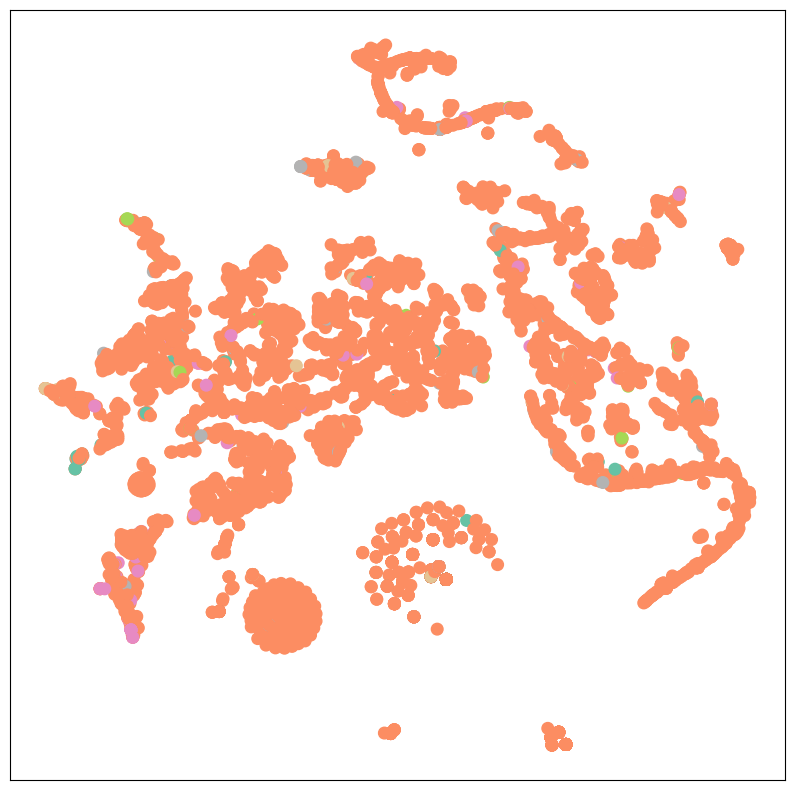

In [389]:
model.eval()

out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

In [390]:
from torch_geometric.nn.models import LabelPropagation

lp = LabelPropagation(num_layers=10, alpha=0.9)

# Run label propagation
y_pred = lp(graph.y, graph.edge_index, graph.train_mask)

# Convert soft outputs to class predictions
y_pred_labels = y_pred.argmax(dim=1)

# Compute accuracy on test set
acc = (y_pred_labels[graph.test_mask] == graph.y[graph.test_mask]).float().mean()
print(f"Label Propagation Accuracy: {acc:.4f}")


Label Propagation Accuracy: 0.7771
